# Program description (Model Performance Evaluation - Module 12)

## 1. **Model Performance Evaluation**
- This module evaluates the **model's performance** based on the prediction results. 
- It performs data analysis on the predicted values and examines the relationship between the **features** and the **predictions** to understand how the features impact the model's predictions.
  
## 2. **Input data:**
- **Prediction results** from the model (located in the `datasets-ml` directory in the current path).
- The corresponding **features** and **labels** from the test set.
  
## 3. **Output:**
- The analysis results, including **performance metrics** and **feature impact analysis**, are saved in the **'Pre_Analysis'** directory under the current model's path.
del's path.

contacts: zhaohf@ihep.ac.cn

#  Import libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, explained_variance_score, max_error, r2_score

##  Version Information

In [2]:
def get_python_version():
    return sys.version
def get_package_version(package_name):
    try:
        module = __import__(package_name)
        version = getattr(module, '__version__', None)
        if version:
            return version
        else:
            return pkg_resources.get_distribution(package_name).version
    except (ImportError, AttributeError, pkg_resources.DistributionNotFound):
        return "Version info not found"

packages = [ 'numpy', 'matplotlib','pandas','sklearn']
for package in packages:
    print(f"{package}: {get_package_version(package)}")
print(f"Python: {get_python_version()}")

numpy: 1.23.5
matplotlib: 3.7.5
pandas: 2.0.3
sklearn: 1.3.2
Python: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


# Parameter Setting (Including Model Parameter Loading)

## Input File Paths:
- **True Label File**:
  - Path: Specifies the file containing the true labels of the test dataset.
  - Example: `"0926-datasets/datasets(JmolNN)-pre-xmu-cn/label_cn_test_JmolNN.txt"`

- **Prediction Results File**:
  - Path: Specifies the file containing the predicted labels from the trained model.
  - Example: `"0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/test_predictions.txt"`

## Output Directory:
- **Analysis Results**:
  - Path: Specifies the directory where analysis results will be saved.
  - Example: `"0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/Pre_Analysis"`

## Key Parameter:
- **analyze_relationship**:
  - Boolean flag indicating whether to analyze the relationship between features and prediction results.
  - Set to `True` to enable feature analysis, or `False` to skip this step.

## File Validation:
- Ensures that all required files exist before proceeding:
  - Raises a `FileNotFoundError` if the true labels file or prediction results file is missing.
  - If `analyze_relationship` is set to `True`, checks the existence of the feature dataset file.

## Data Loading:
- Loads the true labels and predicted labels into memory.
- If `analyze_relationship` is `True`, loads feature data for analysis.

## Output:
- The analysis results are saved in the specified `Pre_Analysis` directory for further evaluation.




In [4]:
# Define input file paths
# Path to the true labels of the test dataset
file_path_label_true = "0926-datasets/datasets(JmolNN)-pre-xmu-cn/label_cn_test_JmolNN.txt"

# Path to the corresponding feature test dataset 
# (Ignore this if not analyzing the relationship between features and labels or if the feature dataset is unavailable)
file_path_feature = "0926-datasets/datasets(JmolNN)-pre-xmu-cn/xmu_test_JmolNN.txt"
# file_path_feature = "0926-datasets-2/datasets(JmolNN)/xmu_test_JmolNN.txt"

# Path to the file containing test predictions
file_path_label_pre = "0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/test_predictions.txt"

# Output directory for storing analysis results
output_dir = "0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/Pre_Analysis"

# Flag indicating whether to analyze the relationship between features and predictions
analyze_relationship = True

# Check if the necessary files exist
if not os.path.exists(file_path_label_true):
    raise FileNotFoundError(f"Label file not found: {file_path_label_true}")
if not os.path.exists(file_path_label_pre):
    raise FileNotFoundError(f"Prediction file not found: {file_path_label_pre}")

# If analyzing the relationship between features and predictions, check if the feature file exists
if analyze_relationship and not os.path.exists(file_path_feature):
    raise FileNotFoundError(f"Feature file not found: {file_path_feature}")

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


In [5]:
label_true = np.loadtxt(file_path_label_true)
label_pre = np.loadtxt(file_path_label_pre)
# Print path information
print(f"True labels loaded from: {file_path_label_true}, shape: {label_true .shape}")
print(f"Predicete labels loaded from: {file_path_label_pre}, shape: {label_pre .shape}")



True labels loaded from: 0926-datasets/datasets(JmolNN)-pre-xmu-cn/label_cn_test_JmolNN.txt, shape: (495,)
Predicete labels loaded from: 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/test_predictions.txt, shape: (495,)


In [6]:
if analyze_relationship:
    # Check if the signature file exists
    if not os.path.exists(file_path_feature):
        raise FileNotFoundError(f"Feature file not found: {file_path_feature}")
    
    # Load feature data from file
    feature_true = np.loadtxt(file_path_feature)
    print(f"True features loaded from: {file_path_feature}, shape: {feature_true.shape}")
    #print(feature_true)
    # analyze_feature_relationship(feature_true)
else:
    print("Feature analysis skipped.")


True features loaded from: 0926-datasets/datasets(JmolNN)-pre-xmu-cn/xmu_test_JmolNN.txt, shape: (495, 1000)


# Evaluation of Model Prediction Results

## Key Calculations:
- **Mean**: Calculates the mean of both the predicted and true values for comparison.
- **Variance**: Calculates the variance for both the predicted and true values.
- **Standard Deviation**: Calculates the standard deviation for both the predicted and true values.

## Outlier Detection:
- **Outlier Detection**: Identifies outliers based on the Z-score (using a threshold). Outliers are considered as values that are more than a certain number of standard deviations away from the mean.
  - Threshold: 2 (can be adjusted for more or fewer outliers).

## Error Metrics:
- **Mean Absolute Error (MAE)**: Measures the average magnitude of errors between predicted and true values.
- **Mean Squared Error (MSE)**: Measures the average of the squared differences between the predicted and true values.
- **Root Mean Squared Error (RMSE)**: The square root of the MSE, which gives an error metric in the same unit as the target variable.
- **Mean Absolute Percentage Error (MAPE)**: Measures the average percentage difference between predicted and true values.
- **Explained Variance Score**: Measures the proportion of variance in the true values that can be explained by the model’s predictions.
- **Max Error**: The largest absolute difference between a predicted value and the corresponding true value.
- **R² Score**: Measures how well the predicted values approximate the true values. A higher R² indicates a better fit.

## Report Generation:
- A detailed analysis report is created summarizing the results of the evaluation metrics, including means, variances, outliers, and various error metrics.

## Output:
- **Report**: The report is saved as a `.txt` file containing the analysis results. It is stored in the specified `output_dir`.
  - Example output file: `"report.txt"`
  
## Example Output Report:
```plaintext
Analysis Report for Predictions and True Values
===============================================
1. Mean:
   - Mean of predictions: 12.3456
   - Mean of true values: 12.3001

2. Variance:
   - Variance of predictions: 2.3456
   - Variance of true values: 2.1234

3. Outliers:
   - Outliers in predictions: [15.7, 20.1]
   - Outliers in true values: [16.5]

4. Error Metrics:
   - Mean Absolute Error (MAE): 0.1234
   - Mean Squared Error (MSE): 0.0156
   - Root Mean Squared Error (RMSE): 0.125
   - Mean Absolute Percentage Error (MAPE): 1.23%
   - Explained Variance: 0.98
   - Max Error: 2.1
   - R² Score: 0.95


In [7]:
# Calculate the mean
mean_label_pre = np.mean(label_pre)
mean_label_true = np.mean(label_true)
# Calculate variance
var_label_pre = np.var(label_pre)
var_label_true = np.var(label_true)
# Calculate standard deviation
std_label_pre = np.std(label_pre)
std_label_true = np.std(label_true)
# Output mean and standard deviation for debugging
print(f"Mean of predicted values: {mean_label_pre}, Standard deviation of predicted values: {std_label_pre}")
print(f"Mean of true values: {mean_label_true}, Standard deviation of true values: {std_label_true}")
# Calculate outliers
def detect_outliers(data, threshold=3):
    mean = np.mean(data)
    std_dev = np.std(data)
    return [val for val in data if np.abs((val - mean) / std_dev) > threshold]
# Adjust the threshold to try to detect more outliers
outliers_label_pre = detect_outliers(label_pre, threshold=2)
outliers_label_true = detect_outliers(label_true, threshold=2)
# Print outliers for debugging
print(f"Prediction outliers: {outliers_label_pre}")
print(f"True value outliers: {outliers_label_true}")
# Calculate MAE, MSE, RMSE, MAPE, Explained Variance Score, Max Error and R²
mae = mean_absolute_error(label_true, label_pre)
mse = mean_squared_error(label_true, label_pre)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(label_true, label_pre)
explained_var = explained_variance_score(label_true, label_pre)
max_err = max_error(label_true, label_pre)
r2 = r2_score(label_true, label_pre)

# Save the results in a dictionary
results = {
    'mean_label_pre': mean_label_pre,
    'mean_label_test': mean_label_true,
    'var_label_pre': var_label_pre,
    'var_label_test': var_label_true,
    'outliers_label_pre': outliers_label_pre,
    'outliers_label_test': outliers_label_true,
    'mae': mae,
    'mse': mse,
    'rmse': rmse,
    'mape': mape,
    'explained_variance': explained_var,
    'max_error': max_err,
    'r2': r2
}

report = f"""
Analysis Report for Predictions and True Values
===============================================
1. Mean:
   - Mean of predictions: {mean_label_pre}
   - Mean of true values: {mean_label_true}

2. Variance:
   - Variance of predictions: {var_label_pre}
   - Variance of true values: {var_label_true}

3. Outliers:
   - Outliers in predictions: {outliers_label_pre}
   - Outliers in true values: {outliers_label_true}

4. Error Metrics:
   - Mean Absolute Error (MAE): {mae}
   - Mean Squared Error (MSE): {mse}
   - Root Mean Squared Error (RMSE): {rmse}
   - Mean Absolute Percentage Error (MAPE): {mape}
   - Explained Variance: {explained_var}
   - Max Error: {max_err}
   - R² Score: {r2}
"""
print(report)
# Save the report to a file
report_path = os.path.join(output_dir, 'report.txt')
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)
#  You can also save the results as CSV or JSON files
#csv_path = os.path.join(output_dir, 'results.csv')
#pd.DataFrame([results]).to_csv(csv_path, index=False)



Mean of predicted values: 5.785858585858586, Standard deviation of predicted values: 2.8231728730120533
Mean of true values: 5.761616161616161, Standard deviation of true values: 2.8617543207029557
Prediction outliers: [12.0, 12.0, 12.0]
True value outliers: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]

Analysis Report for Predictions and True Values
1. Mean:
   - Mean of predictions: 5.785858585858586
   - Mean of true values: 5.761616161616161

2. Variance:
   - Variance of predictions: 7.970305070911131
   - Variance of true values: 8.189637792062035

3. Outliers:
   - Outliers in predictions: [12.0, 12.0, 12.0]
   - Outliers in true values: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]

4. Error Metrics:
   - Mean Absolute Error (MAE): 0.3474747474747475
   - Mean Squared Error (MSE): 0.39191919191919194
   - Root Mean Squared Error (RMSE): 0.6260344973874779
   - Mean Absolute Percentage Error (MAPE): 0.05718826067310916
   - Explained Variance: 0.95

# Plotting Predicted vs True Values

## Plot 1: Distribution Histogram of True Labels
- A histogram is plotted for the **true labels**, showcasing the frequency distribution.
- **Output**: The plot is saved as `true_label_distribution.png`.

## Plot 2: Distribution Histogram of Predicted Labels
- A histogram is plotted for the **predicted labels**, displaying their frequency distribution.
- **Output**: The plot is saved as `predicted_label_distribution.png`.

## Plot 3: Line Chart of True vs Predicted Values
- A line chart is plotted to visualize the relationship between **true values** and **predicted values**.
- The **true values** are plotted in **yellow** and the **predicted values** in **blue**.
- **Output**: The plot is saved as `true_vs_predicted.png`.

## Plot 4: Scatter Plot of True vs Predicted Values
- A scatter plot is generated showing the **true values** against the **predicted values**.
- **Output**: The plot is saved as `scatter_plot.png`.

## Plot 5: KDE Density Plot of True vs Predicted Values
- A **Kernel Density Estimate (KDE)** plot is created to visualize the density distribution between the **true values** and **predicted values**.
- The **true values** and **predicted values** are represented as a **density map**.
- **Output**: The plot is saved as `kde_density_plot.png`.

## Additional Information:
- **Visualization Type**: Histograms, line charts, scatter plots, and KDE density plots are used to analyze the accuracy and distribution of predicted and true values.
- **File Output**: All visualizations are saved in the specified `output_dir`.


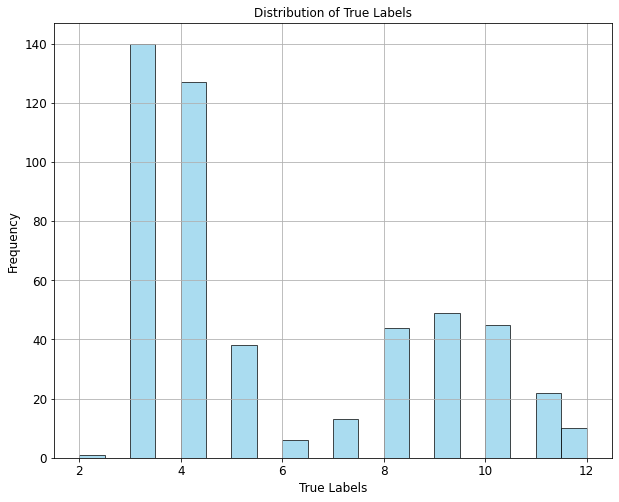

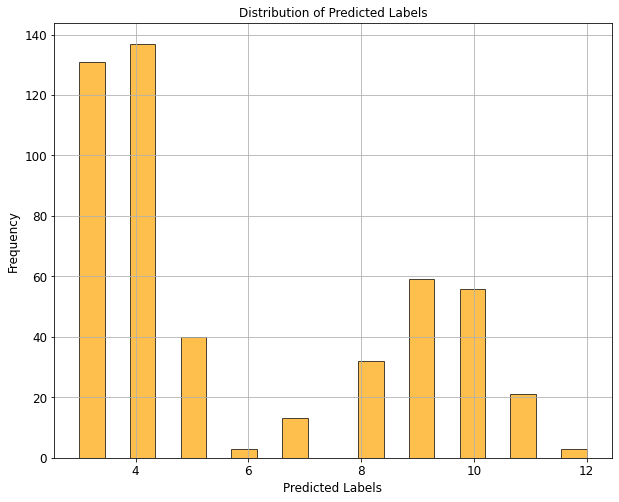

In [8]:
# Plot a distribution histogram of the true labels
plt.figure(figsize=(10, 8))
plt.hist(label_true, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("True Labels", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of True Labels", fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.grid(True)
true_label_distribution_path = os.path.join(output_dir, "true_label_distribution.png")
plt.savefig(true_label_distribution_path)
plt.show()
#Plot a distribution histogram of the predicted labels
plt.figure(figsize=(10, 8))
plt.hist(label_pre, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Predicted Labels", fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.grid(True)
predicted_label_distribution_path = os.path.join(output_dir, "predicted_label_distribution.png")
plt.savefig(predicted_label_distribution_path)
plt.show()

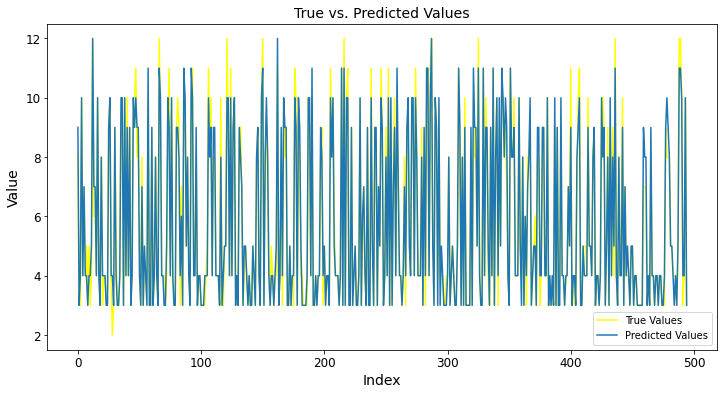

In [9]:
# Plot a line chart
#data_pre=predictions
plt.figure(figsize=(12, 6))
plt.plot(label_true, color='yellow', label="True Values")
plt.plot(label_pre, label="Predicted Values")
plt.xlabel("Index",fontsize=14)
plt.ylabel("Value",fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.legend()
plt.title("True vs. Predicted Values",fontsize=14)
output_file = os.path.join(output_dir, "true_vs_predicted.png")
plt.savefig(output_file)
plt.show()


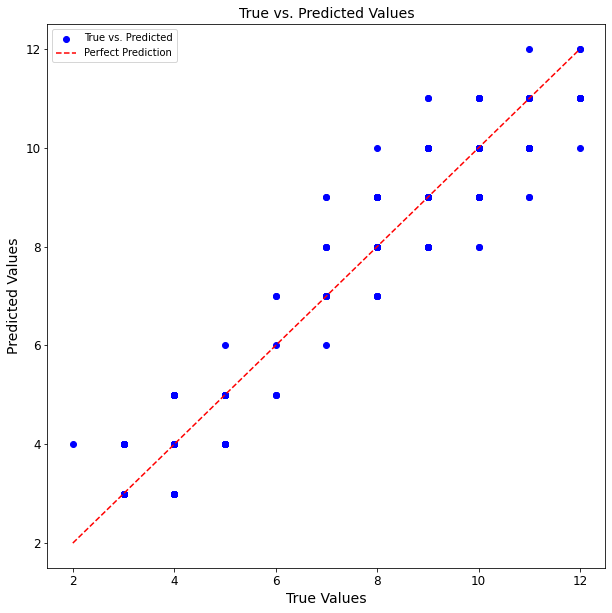

In [10]:
# Plot a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(label_true, label_pre, color='blue', label='True vs. Predicted')
plt.plot([label_true.min(), label_true.max()], [label_true.min(), label_true.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("True Values",fontsize=14)
plt.ylabel("Predicted Values",fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title("True vs. Predicted Values",fontsize=14)
plt.legend()
output_path_scatter = os.path.join(output_dir, "scatter_plot.png")
#os.makedirs(os.path.dirname(output_path_scatter), exist_ok=True)
#plt.savefig(output_path_scatter)
plt.show()


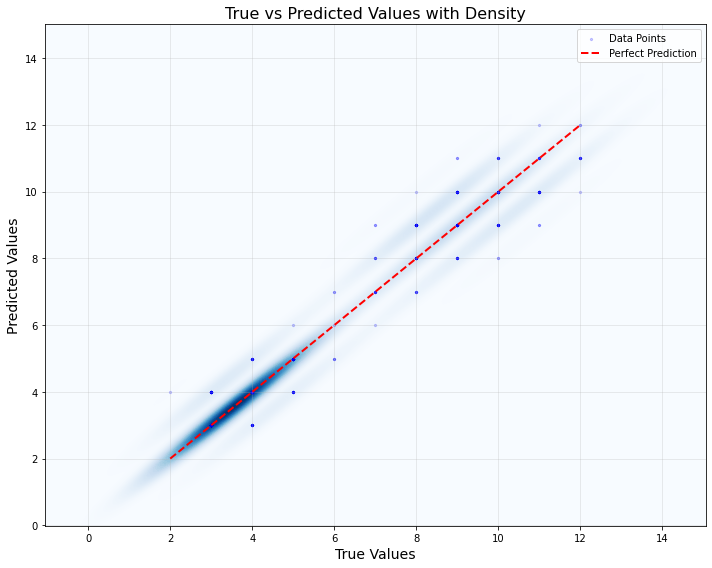

In [11]:
output_path_kde = os.path.join(output_dir, "kde_density_plot.png")
plt.figure(figsize=(10, 8))
sns.kdeplot(x=label_true, y=label_pre, cmap="Blues", fill=True, thresh=0, levels=100) 
plt.scatter(label_true, label_pre, color='blue', s=5, alpha=0.2, label="Data Points")  
plt.plot([label_true.min(), label_true.max()], [label_true.min(), label_true.max()], 
         color='red', linestyle='--', linewidth=2, label="Perfect Prediction")
plt.xlabel("True Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("True vs Predicted Values with Density", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(output_path_kde)
plt.show()

# Analysis and Visualization of Prediction Differences

## 1. **Difference Distribution Graph**
- The **absolute difference** between the true values and predicted values is calculated and visualized using a histogram.
- **Output**: The plot is saved as `difference_distribution.png`.

## 2. **Box Plot of Differences**
- A **box plot** is created to visualize the distribution of the differences between true and predicted values.
- **Output**: The plot is saved as `boxplot_differences.png`.

## 3. **Clustering of Differences**
- The **differences** are clustered using **K-means clustering** (with `n_clusters=3`).
- **Cluster Counts**: The number of data points in each cluster is calculated and printed.
- **Cluster Means**: The mean absolute difference for each cluster is computed.

### Box Plot of Absolute Differences for Each Cluster:
- **Box plot** visualizing the absolute differences within each cluster, with means indicated.
- **Output**: The plot is saved as `boxplot_absolute_differences.png`.

## 4. **Analysis of Feature Relationship (if enabled)**
- If the `analyze_relationship` flag is set to `True`, the following additional analysis is performed:
    - **Feature Visualization**: Spectra of each feature in the clusters are plotted. The mean difference for each cluster is shown as a text label.
    - **Output**: Spectra for each cluster are saved as `cluster_{i}_spalComponent Analysis (PCA)**
- **PCA** is performed on the feature set (`X_test`), reducing it to two principal components.
- **Coloring**: The scatter plot is colored according to the **absolute difference** between true and predicted values.
- **Explained Variance**: The explained variance of the first two principal components is displayed in the plot title.
- **Output**: The PCA plot is saved as `pca_absolute_difference.png`.


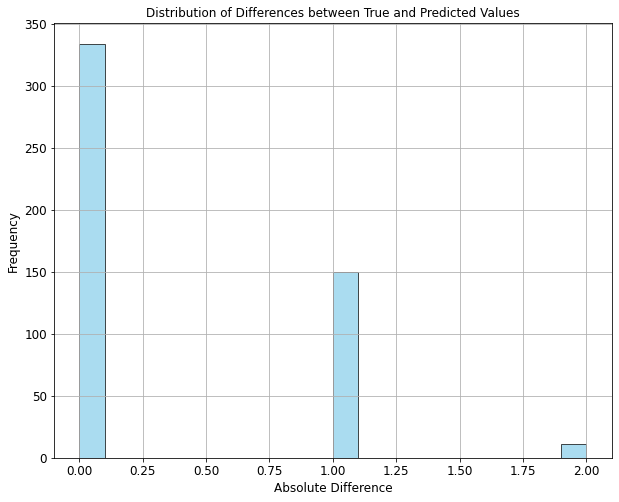

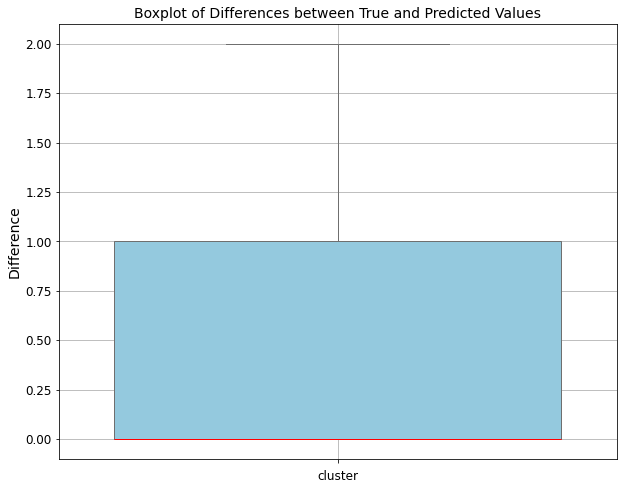

In [12]:
# Calculate the difference
differences = np.abs(label_true - label_pre)

# Plot a difference distribution graph
plt.figure(figsize=(10, 8))
plt.hist(differences, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Absolute Difference",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title("Distribution of Differences between True and Predicted Values",fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.grid(True)
difference_distribution_path = os.path.join(output_dir, "difference_distribution.png")
plt.savefig(difference_distribution_path)
plt.show()

# Plot box plot
plt.figure(figsize=(10, 8))
sns.boxplot(y=differences, color='skyblue', medianprops={'color': 'red'})
plt.ylabel("Difference",fontsize=14)
plt.title("Boxplot of Differences between True and Predicted Values",fontsize=14)
plt.xlabel("cluster",fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.grid(True)
boxplot_differences_path = os.path.join(output_dir,"boxplot_differences.png")
plt.savefig(boxplot_differences_path)
plt.show()

/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Counts: [334 150  11]


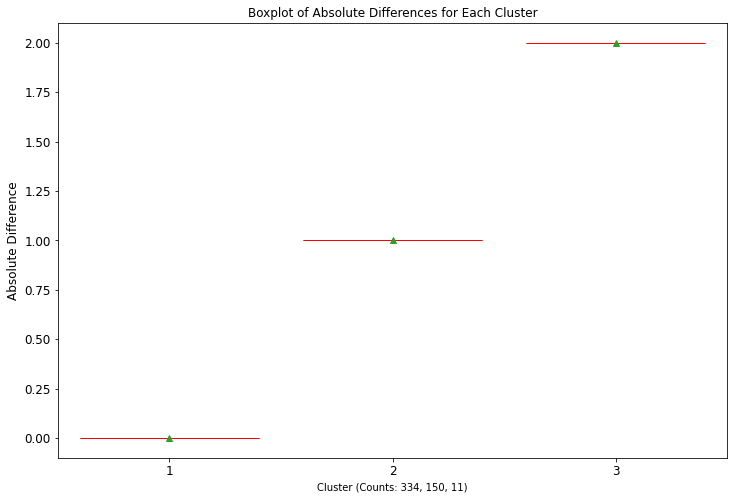

In [13]:
# Calculate the absolute difference between the predicted value and the true value
n_clusters = 3
differences = np.abs(label_true - label_pre)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(differences.reshape(-1, 1))  
clusters = clusters + 1
cluster_counts = np.bincount(clusters)[1:]
print("Cluster Counts:", cluster_counts)
# Calculate the mean of the predicted differences for each category
cluster_means = []
for i in range(1,n_clusters+1):
    cluster_data_indices = np.where(clusters == i)[0]
    cluster_mean = np.mean(differences[cluster_data_indices])
    cluster_means.append(cluster_mean)
# Plot box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x=clusters, y=differences, showmeans=True,color='skyblue', medianprops={'color': 'red'})  # Display the mean
plt.xlabel("Cluster (Counts: " + ', '.join(map(str, cluster_counts)) + ")")  # Add quantity information on the horizontal axis
plt.ylabel("Absolute Difference",fontsize=12)
plt.title("Boxplot of Absolute Differences for Each Cluster",fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
output_path_label = os.path.join(output_dir, "pre_cluster")
os.makedirs(output_path_label, exist_ok=True)
output_path = os.path.join(output_path_label, "boxplot_absolute_differences.png")
plt.savefig(output_path)
plt.show()



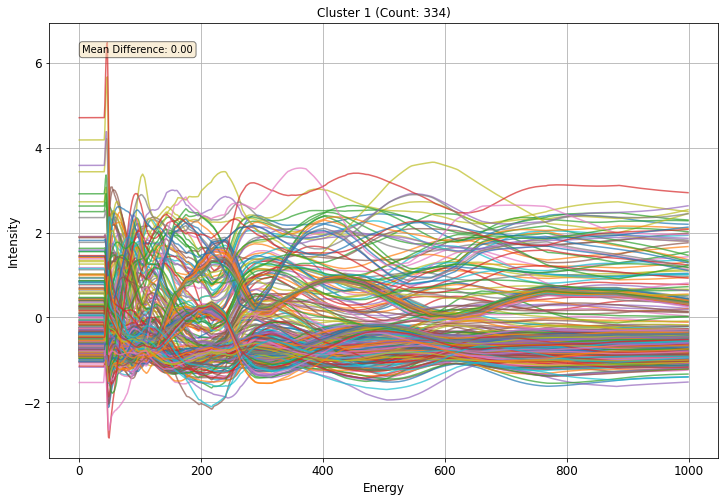

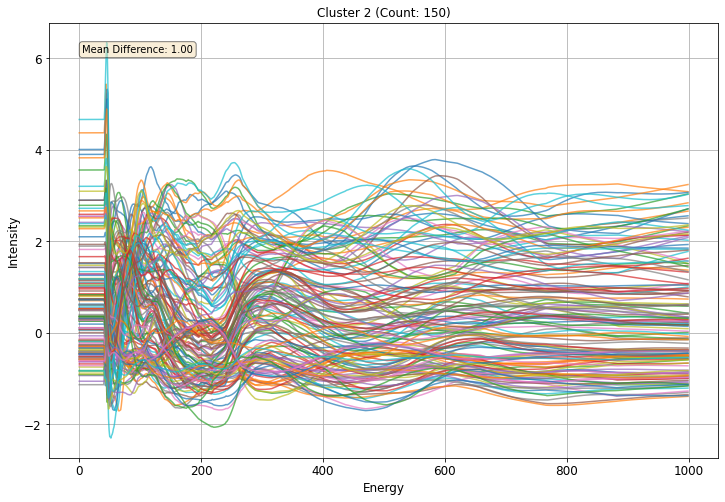

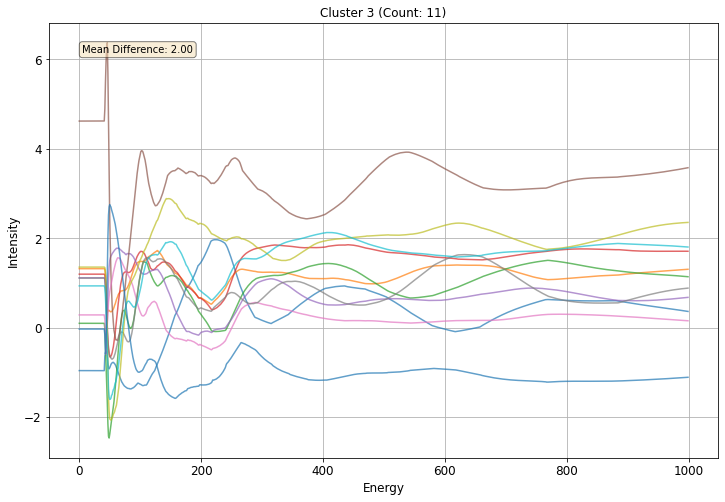

In [14]:
if analyze_relationship:
    for i in range(1,n_clusters+1):
        cluster_data_indices = np.where(clusters == i)[0]
        cluster_chi_spectra = feature_true[cluster_data_indices]

        plt.figure(figsize=(12, 8))
        for j, spectrum in enumerate(cluster_chi_spectra):
            plt.plot(spectrum, alpha=0.7)

        # Add mean information text label
        plt.text(0.05, 0.95, f'Mean Difference: {cluster_means[i-1]:.2f}', transform=plt.gca().transAxes,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.xticks(rotation=0, fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.xlabel("Energy", fontsize=12)
        plt.ylabel("Intensity", fontsize=12)
        plt.title(f"Cluster {i} (Count: {cluster_counts[i-1]})", fontsize=12)  # Add quantity information to the title
        plt.grid(True)
        output_path_feature = os.path.join(output_dir, "pre_cluster", f"cluster_{i}_spectra.png")
        plt.savefig(output_path_feature)
        plt.show()



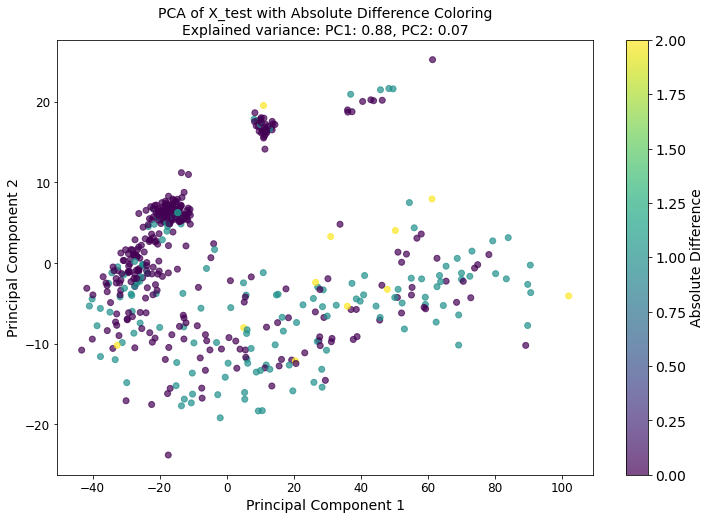

In [15]:
if analyze_relationship:
    differences = np.abs(label_true - label_pre)
    # Principal Component Analysis (PCA)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(feature_true)
    # Get explained variance
    explained_variance = pca.explained_variance_ratio_
    explained_variance_str = f"Explained variance: PC1: {explained_variance[0]:.2f}, PC2: {explained_variance[1]:.2f}"

    # Plot the first two principal components
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=differences, cmap='viridis', alpha=0.7)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    cbar = plt.colorbar(scatter, label='Absolute Difference')
    cbar.ax.tick_params(labelsize=14)  # Set the color bar scale font size
    cbar.set_label('Absolute Difference', fontsize=14)
    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)
    plt.title(f"PCA of X_test with Absolute Difference Coloring\n{explained_variance_str}", fontsize=14)
    output_path_pca = os.path.join(output_dir, "pca_absolute_difference.png")
    plt.savefig(output_path_pca)
    plt.show()
